In [1]:
from src.dataloader import LandCoverData

import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm import tqdm
import os

%load_ext autoreload
%autoreload 2

In [2]:
#path="../"
path="/scratch/izar/nkaltenr/"

dataset = LandCoverData(path, transforms=None, split="train")
#dataset = LandCoverData(path, split="train")

In [3]:
cmap = clr.LinearSegmentedColormap.from_list('custom_datacolor', dataset.colormap_names, N=256)
#cmap='viridis'
#cmap=dataset.colormap

In [4]:
tt_class=np.zeros(len(dataset.LABEL_CLASSES))
for _, label in tqdm(dataset):
    class_list, class_count = torch.unique(label, return_counts=True)  
    for i, c in enumerate(class_list):
        tt_class[c]+=class_count[i]

100%|███████████████████████████████████████| 7357/7357 [03:52<00:00, 31.69it/s]


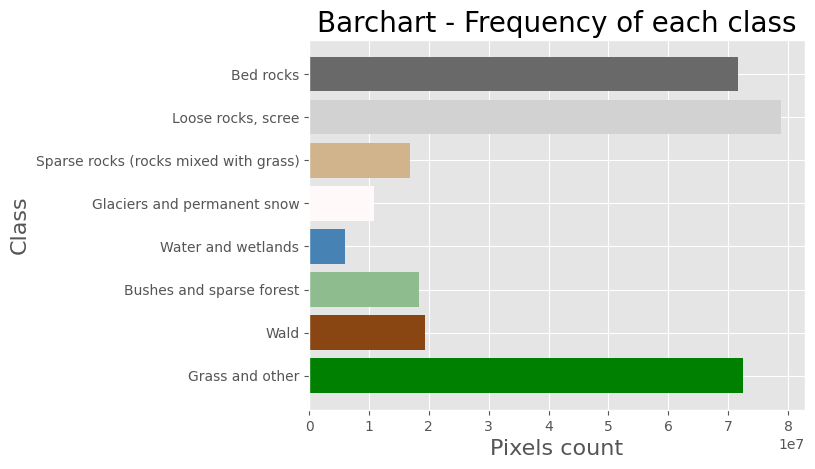

In [5]:
plt.style.use('ggplot')

labels = [k for k in dataset.LABEL_CLASSES.keys()]
indexes = np.arange(len(labels))

rescale = lambda indexes: (indexes - np.min(indexes)) / (np.max(indexes) - np.min(indexes))

width = 0.8
plt.barh(indexes, tt_class, color=cmap(rescale(indexes)))
plt.yticks(indexes, labels)
plt.xlabel('Pixels count', fontsize=16)
plt.ylabel('Class', fontsize=16)
plt.title('Barchart - Frequency of each class',fontsize=20)
plt.show()

In [6]:
# Compute fraction of each class of the dataset
total_pixels = tt_class.sum()
frac_class = [c/total_pixels for c in tt_class]
print(frac_class)

[0.24643106446206095, 0.06570622957842312, 0.062330682962183345, 0.020174477207666023, 0.03669090817922338, 0.05728250507725563, 0.2680321487788832, 0.24335198375430434]


In [4]:
# plot individual samples
from ipywidgets import widgets
from ipywidgets import interact
%matplotlib inline

names = [k for k in dataset.LABEL_CLASSES.keys()]
toPIL = T.ToPILImage()

style = {'description_width': 'initial'}
widget=widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(dataset),
    step=1,
    description=f"Index data: (max={len(dataset)})",
    disabled=False,
    style=style
)
widget_cb=widgets.Checkbox(
    value=True,
    description='Colorbar',
    disabled=False,
    indent=False
)

@interact(idx=widget, flag_colorbar=widget_cb)
def plot_sample(idx=0, flag_colorbar=False):
    img, label = dataset[idx]
    class_mapping = {v: k for k, v in dataset.LABEL_CLASSES.items()}
    class_list, class_count = torch.unique(label, return_counts=True) 
    
    roffset=1
    if flag_colorbar:
        roffset=1.07
    fig, ax = plt.subplots(1,2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, roffset]})      

    ax[0].imshow(toPIL(img))
    pim=ax[1].imshow(toPIL(label), cmap=cmap, vmin=0, vmax=len(dataset.LABEL_CLASSES))
    
    if flag_colorbar:
        class_list, _ = torch.unique(label, return_counts=True)
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = fig.colorbar(pim, cax=cax, ax=ax.ravel().tolist())
        if cmap==dataset.colormap:
            cbar.set_ticks([i.item()+0.5 for i in class_list])
        else:
            cbar.set_ticks([i.item() for i in class_list])
        cbar.set_ticklabels([class_mapping[i.item()] for i in class_list])

    ax[0].axis("off")
    ax[1].axis("off")
    #ax[2].axis("off")
    ax[0].set_title(f"Image")
    ax[1].set_title(f"Label")
    
    plt.show()
    
    print("Label contains:")
    for i, v in enumerate(class_list):
        print(f"   - {class_mapping[v.item()]}: {class_count[i]} times.")

interactive(children=(BoundedIntText(value=0, description='Index data: (max=7357)', max=7357, style=Descriptio…

### Sanity check in the training dataset (remove all black images)

In [8]:
tt_class=np.zeros(len(dataset.LABEL_CLASSES))
index_img = 0
for img, _ in tqdm(dataset):
    # Image is all black if the sum of the value of the pixels is equal to zero
    if img.sum() == 0:
        print(index_img)
    index_img += 1

100%|██████████████████████████████████████| 7357/7357 [00:41<00:00, 178.10it/s]


## Preprocessing

### It's only the last 11 training images that are all black 

In [21]:
dataset2 = LandCoverData(path, transforms=None, split="train", ignore_last_number=11)
print(len(dataset2))

7346


### Compute mean and std per channel (R,G,B)

In [26]:
tt_class=np.zeros(len(dataset2.LABEL_CLASSES))
std = np.array([0.,0.,0.])
mean_rgb = np.array([0.,0.,0.])

for img, _ in tqdm(dataset2):
    std += img.std((1,2)).numpy() #((img[j,:,:] - mean_rgb[j])**2).sum()/(img.shape[1]*img.shape[2])
    mean_rgb += img.mean((1,2)).numpy()

mean_rgb = mean_rgb / len(dataset2)
std = std/len(dataset2)
print(f"mean : {mean_rgb}")
print(f"std : {std}")

100%|██████████████████████████████████████| 7346/7346 [00:46<00:00, 157.58it/s]

mean : [0.43315597 0.48058005 0.42299773]
std : [0.13840764 0.13066204 0.11168083]


In [34]:
tt_class=np.zeros(len(dataset2.LABEL_CLASSES))

std = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])

for img, _ in tqdm(dataset2):
    for j in range(3):
            stdTemp[j] += ((img[j,:,:] - mean_rgb[j])**2).sum()/(img.shape[1]*img.shape[2])

std = np.sqrt(stdTemp/len(dataset2))
print(f"std : {std}")

100%|███████████████████████████████████████| 7346/7346 [03:35<00:00, 34.02it/s]

std : [0.23198403 0.22022461 0.19084829]


### After normalization the mean should be close to 0 and std close to 1

In [37]:
dataset3 = LandCoverData(path, split="train", ignore_last_number=11)

In [25]:
tt_class=np.zeros(len(dataset3.LABEL_CLASSES))
std = np.array([0.,0.,0.])
mean_rgb = np.array([0.,0.,0.])

for img, _ in tqdm(dataset3):
    std += img.std((1,2)).numpy() #((img[j,:,:] - mean_rgb[j])**2).sum()/(img.shape[1]*img.shape[2])
    mean_rgb += img.mean((1,2)).numpy()

mean_rgb = mean_rgb / len(dataset3)
std = std/len(dataset3)
print(f"mean : {mean_rgb}")
print(f"std : {std}")

100%|██████████████████████████████████████| 7346/7346 [00:49<00:00, 147.93it/s]

mean : [-1.40181300e-07 -1.35390797e-07 -8.94784966e-08]
std : [1.00000003 0.99999999 1.00000005]


In [38]:
tt_class=np.zeros(len(dataset3.LABEL_CLASSES))
mean_rgb = np.array([0.,0.,0.])

for img, _ in tqdm(dataset3):
    mean_rgb += img.mean((1,2)).numpy()

mean_rgb = mean_rgb / len(dataset3)
print(f"mean : {mean_rgb}")

100%|██████████████████████████████████████| 7346/7346 [00:40<00:00, 183.13it/s]

mean : [-8.63524326e-08 -8.08933123e-08 -5.31044057e-08]


In [39]:
tt_class=np.zeros(len(dataset3.LABEL_CLASSES))

std = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])

for img, _ in tqdm(dataset3):
    for j in range(3):
            stdTemp[j] += ((img[j,:,:] - mean_rgb[j])**2).sum()/(img.shape[1]*img.shape[2])

std = np.sqrt(stdTemp/len(dataset3))
print(f"std : {std}")

100%|██████████████████████████████████████| 7346/7346 [00:42<00:00, 173.64it/s]

std : [1.00000136 1.00000156 1.0000004 ]


# DATA AUGMENTATION TEST

In [45]:
dataset2 = LandCoverData(path, transforms=None, split="train", ignore_last_number=11)

In [46]:
path_augmented_rgb ="/scratch/izar/nkaltenr/ipeo_data/augmented_data_rgb/"
path_augmented_label ="/scratch/izar/nkaltenr/ipeo_data/augmented_data_label/"

In [47]:
# Water and wetlands is less represented, -> index=4

index_augmentation=5
toPIL = T.ToPILImage()

tt_class=np.zeros(len(dataset2.LABEL_CLASSES))
index_label=0
for img, label in tqdm(dataset2):
    class_list, class_count = torch.unique(label, return_counts=True) 
    if index_augmentation in class_list:
        #print(index_label)
        #fig, ax = plt.subplots(1,8, figsize=(16, 20))
        #ax[0].imshow(toPIL(img))
        #ax[1].imshow(toPIL(label), cmap=cmap, vmin=0, vmax=len(dataset2.LABEL_CLASSES))
        for i in range(1,4):
            rotation_deg = i * 90 #Only performs flip
            path = "/"
            name_image = f"{index_label}_{i}_rgb"
            name_label = f"{index_label}_{i}_label"
            
            rotated = toPIL(img).rotate(rotation_deg,expand=0)
            #ax[i*2].imshow(rotated)
            rotated.save(path_augmented_rgb+name_image+".tif")
            rotated = toPIL(label).rotate(rotation_deg,expand=0)
            rotated.save(path_augmented_label+name_label+".tif")
            #ax[i*2+1].imshow(rotated, cmap=cmap, vmin=0, vmax=len(dataset2.LABEL_CLASSES))
    index_label+=1

100%|███████████████████████████████████████| 7346/7346 [01:36<00:00, 75.94it/s]


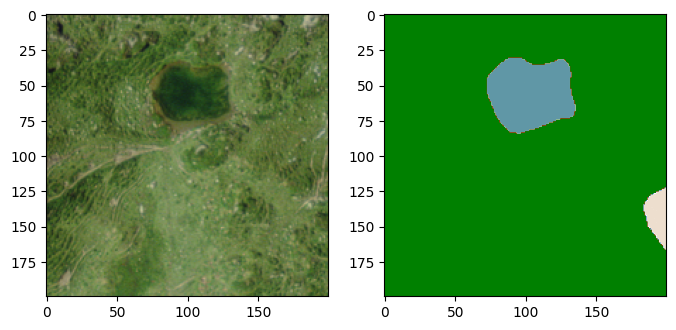

In [16]:
img = Image.open(path_augmented_rgb+"420_3_rgb.tif")
label = Image.open(path_augmented_label+"420_3_label.tif")

fig, ax = plt.subplots(1,2, figsize=(8, 10))
ax[0].imshow(img)
ax[1].imshow(label, cmap=cmap, vmin=0, vmax=len(dataset2.LABEL_CLASSES))

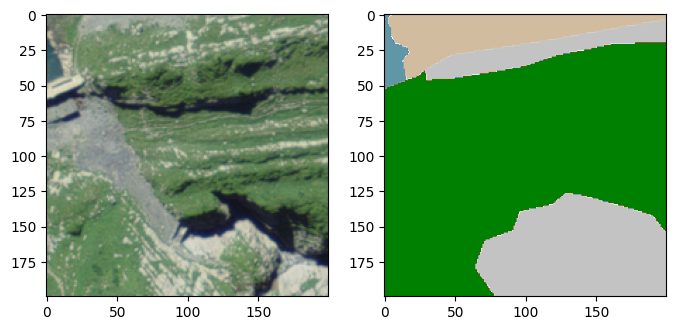

In [16]:
name_list = os.listdir(path_augmented_rgb)
for name in name_list:
    name_without_extension = name[:-4]
    img = Image.open(path_augmented_rgb+name_without_extension+".tif")
    label = Image.open(path_augmented_label+name_without_extension[:-3]+"label.tif")

    fig, ax = plt.subplots(1,2, figsize=(8, 10))
    ax[0].imshow(img)
    ax[1].imshow(label, cmap=cmap, vmin=0, vmax=len(dataset2.LABEL_CLASSES))
    break

In [48]:
path="/scratch/izar/nkaltenr/"
dataset_final = LandCoverData(path, transforms=None, split="train", ignore_last_number=11, use_augmented=True)

In [49]:
tt_class=np.zeros(len(dataset_final.LABEL_CLASSES))
for _, label in tqdm(dataset_final):
    class_list, class_count = torch.unique(label, return_counts=True)  
    for i, c in enumerate(class_list):
        tt_class[c]+=class_count[i]

100%|█████████████████████████████████████| 19325/19325 [03:38<00:00, 88.48it/s]


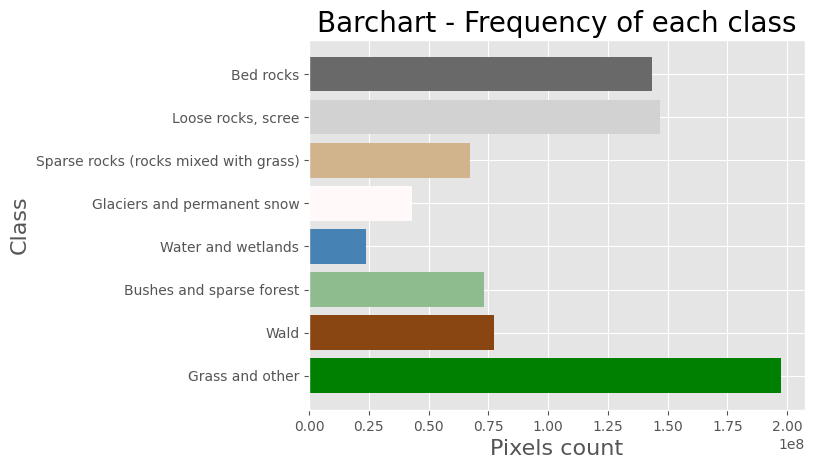

In [50]:
plt.style.use('ggplot')

labels = [k for k in dataset_final.LABEL_CLASSES.keys()]
indexes = np.arange(len(labels))

rescale = lambda indexes: (indexes - np.min(indexes)) / (np.max(indexes) - np.min(indexes))

width = 0.8
plt.barh(indexes, tt_class, color=cmap(rescale(indexes)))
plt.yticks(indexes, labels)
plt.xlabel('Pixels count', fontsize=16)
plt.ylabel('Class', fontsize=16)
plt.title('Barchart - Frequency of each class',fontsize=20)
plt.show()

In [51]:
# Compute fraction of each class of the dataset
total_pixels = tt_class.sum()
frac_class = [c/total_pixels for c in tt_class]
print(frac_class)

[0.2556308607974819, 0.10005724296791237, 0.0949169256654561, 0.0307215829481922, 0.05587288726581635, 0.08720499563627286, 0.18981876206345794, 0.18577674265541033]


In [52]:
[0.24643106446206095, 0.06570622957842312, 0.062330682962183345, 0.020174477207666023, 0.03669090817922338, 0.05728250507725563, 0.2680321487788832, 0.24335198375430434]

[0.24643106446206095,
 0.06570622957842312,
 0.062330682962183345,
 0.020174477207666023,
 0.03669090817922338,
 0.05728250507725563,
 0.2680321487788832,
 0.24335198375430434]